In [434]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

def plot_confusion_matrix(confusion_mat, class_names):
    fig, ax = plt.subplots(figsize=(50, 50))
    ax.matshow(confusion_mat, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i, s=format(confusion_mat[i,j], '.4f'), va='center', ha='center', fontsize=50)
    plt.xticks(np.arange(len(class_names)), class_names, fontsize=50)
    plt.yticks(np.arange(len(class_names)), class_names, fontsize=50)
    plt.xlabel('Prediction', fontsize=80)
    plt.ylabel('Target', fontsize=80)
    plt.title('Confusion Matrix\n')

def holdout_func(X, y, mod, i):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
        
    print("Classification accuracy:", metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))

    if i > 3:
        confusion_mat = metrics.confusion_matrix(y_test, y_pred, labels=class_names)
        plot_confusion_matrix(confusion_mat, class_names)

def KFold_func(X, y, num_split, mod):
    kf = KFold(n_splits=num_split, shuffle=False)

    y_pred_sum = 0
    confusion_mat_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        y_pred_sum += metrics.accuracy_score(y_test, y_pred)
        confusion_mat_list.append(metrics.confusion_matrix(y_test, y_pred, labels=class_names))
        
    print("accuracy:", y_pred_sum / kf.get_n_splits(kf))
    print(metrics.classification_report(y_test, y_pred))

    mean_confusion_mat = np.mean(confusion_mat_list, axis=0)
    plot_confusion_matrix(mean_confusion_mat, class_names)

In [435]:
notification_df = pd.read_csv('../../data/notification_sequence.csv', sep = ',')
notification_df = pd.DataFrame(notification_df)

# drop '?'
notification_df = notification_df.replace('?', pd.NaT)
notification_df = notification_df.dropna(axis=0)

In [436]:
X_categorical_col = ['gender', 'department', 'scenario']
y_categorical_col = ['tol_111111', 'tol_1122', 'tol_123', 'tol_222', 'tol_24', 'tol_15']
X_usetime_col = ['social_usetime', 'communication_usetime', 'entertainment_usetime', 'news_usetime', 'system_usetime', 'notification_usetime']

X = notification_df.iloc[:, :-6]
y = notification_df.iloc[:, -6:]

In [437]:
# transfer usetime to ratio of total_usetime
for col in X.columns:
    if col not in X_categorical_col:
        X[col] = X[col].astype(int)

X['total_usetime'] += 1
for usetime in X_usetime_col:
    X[usetime] += 1

X.loc[:, X_usetime_col] = X.loc[:, X_usetime_col].div(X['total_usetime'], axis=0)
X = X.drop(['total_usetime'], axis=1)

In [438]:
# label encoding
labelencoder = LabelEncoder()
for i in X_categorical_col:
    X[i] = labelencoder.fit_transform(X[i])
le_name_mapping = []
for i in y_categorical_col:
    labelencoder.fit(y[i])
    le_name_mapping.append(dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_))))

# handle X with categorical in 'one-hot encode'
X = pd.get_dummies(X, columns = X_categorical_col)

X = preprocessing.normalize(X)

Random Forest with k = 15 :
tol_111111 Classification accuracy: 0.17355371900826447
              precision    recall  f1-score   support

      censwy       0.00      0.00      0.00         2
      censyw       0.00      0.00      0.00         1
      cesnwy       0.00      0.00      0.00         2
      cesnyw       0.00      0.00      0.00         3
      cesynw       0.00      0.00      0.00         1
      cewnsy       0.00      0.00      0.00         1
      cewsyn       0.00      0.00      0.00         1
      cnsewy       0.00      0.00      0.00         2
      cnswey       0.11      0.17      0.13         6
      cnswye       0.00      0.00      0.00         3
      cnsywe       1.00      0.50      0.67         2
      cnwsey       0.00      0.00      0.00         5
      cnwsye       1.00      0.50      0.67         2
      cnwyse       0.00      0.00      0.00         0
      csenwy       0.08      0.22      0.12         9
      csenyw       0.00      0.00      0.00        

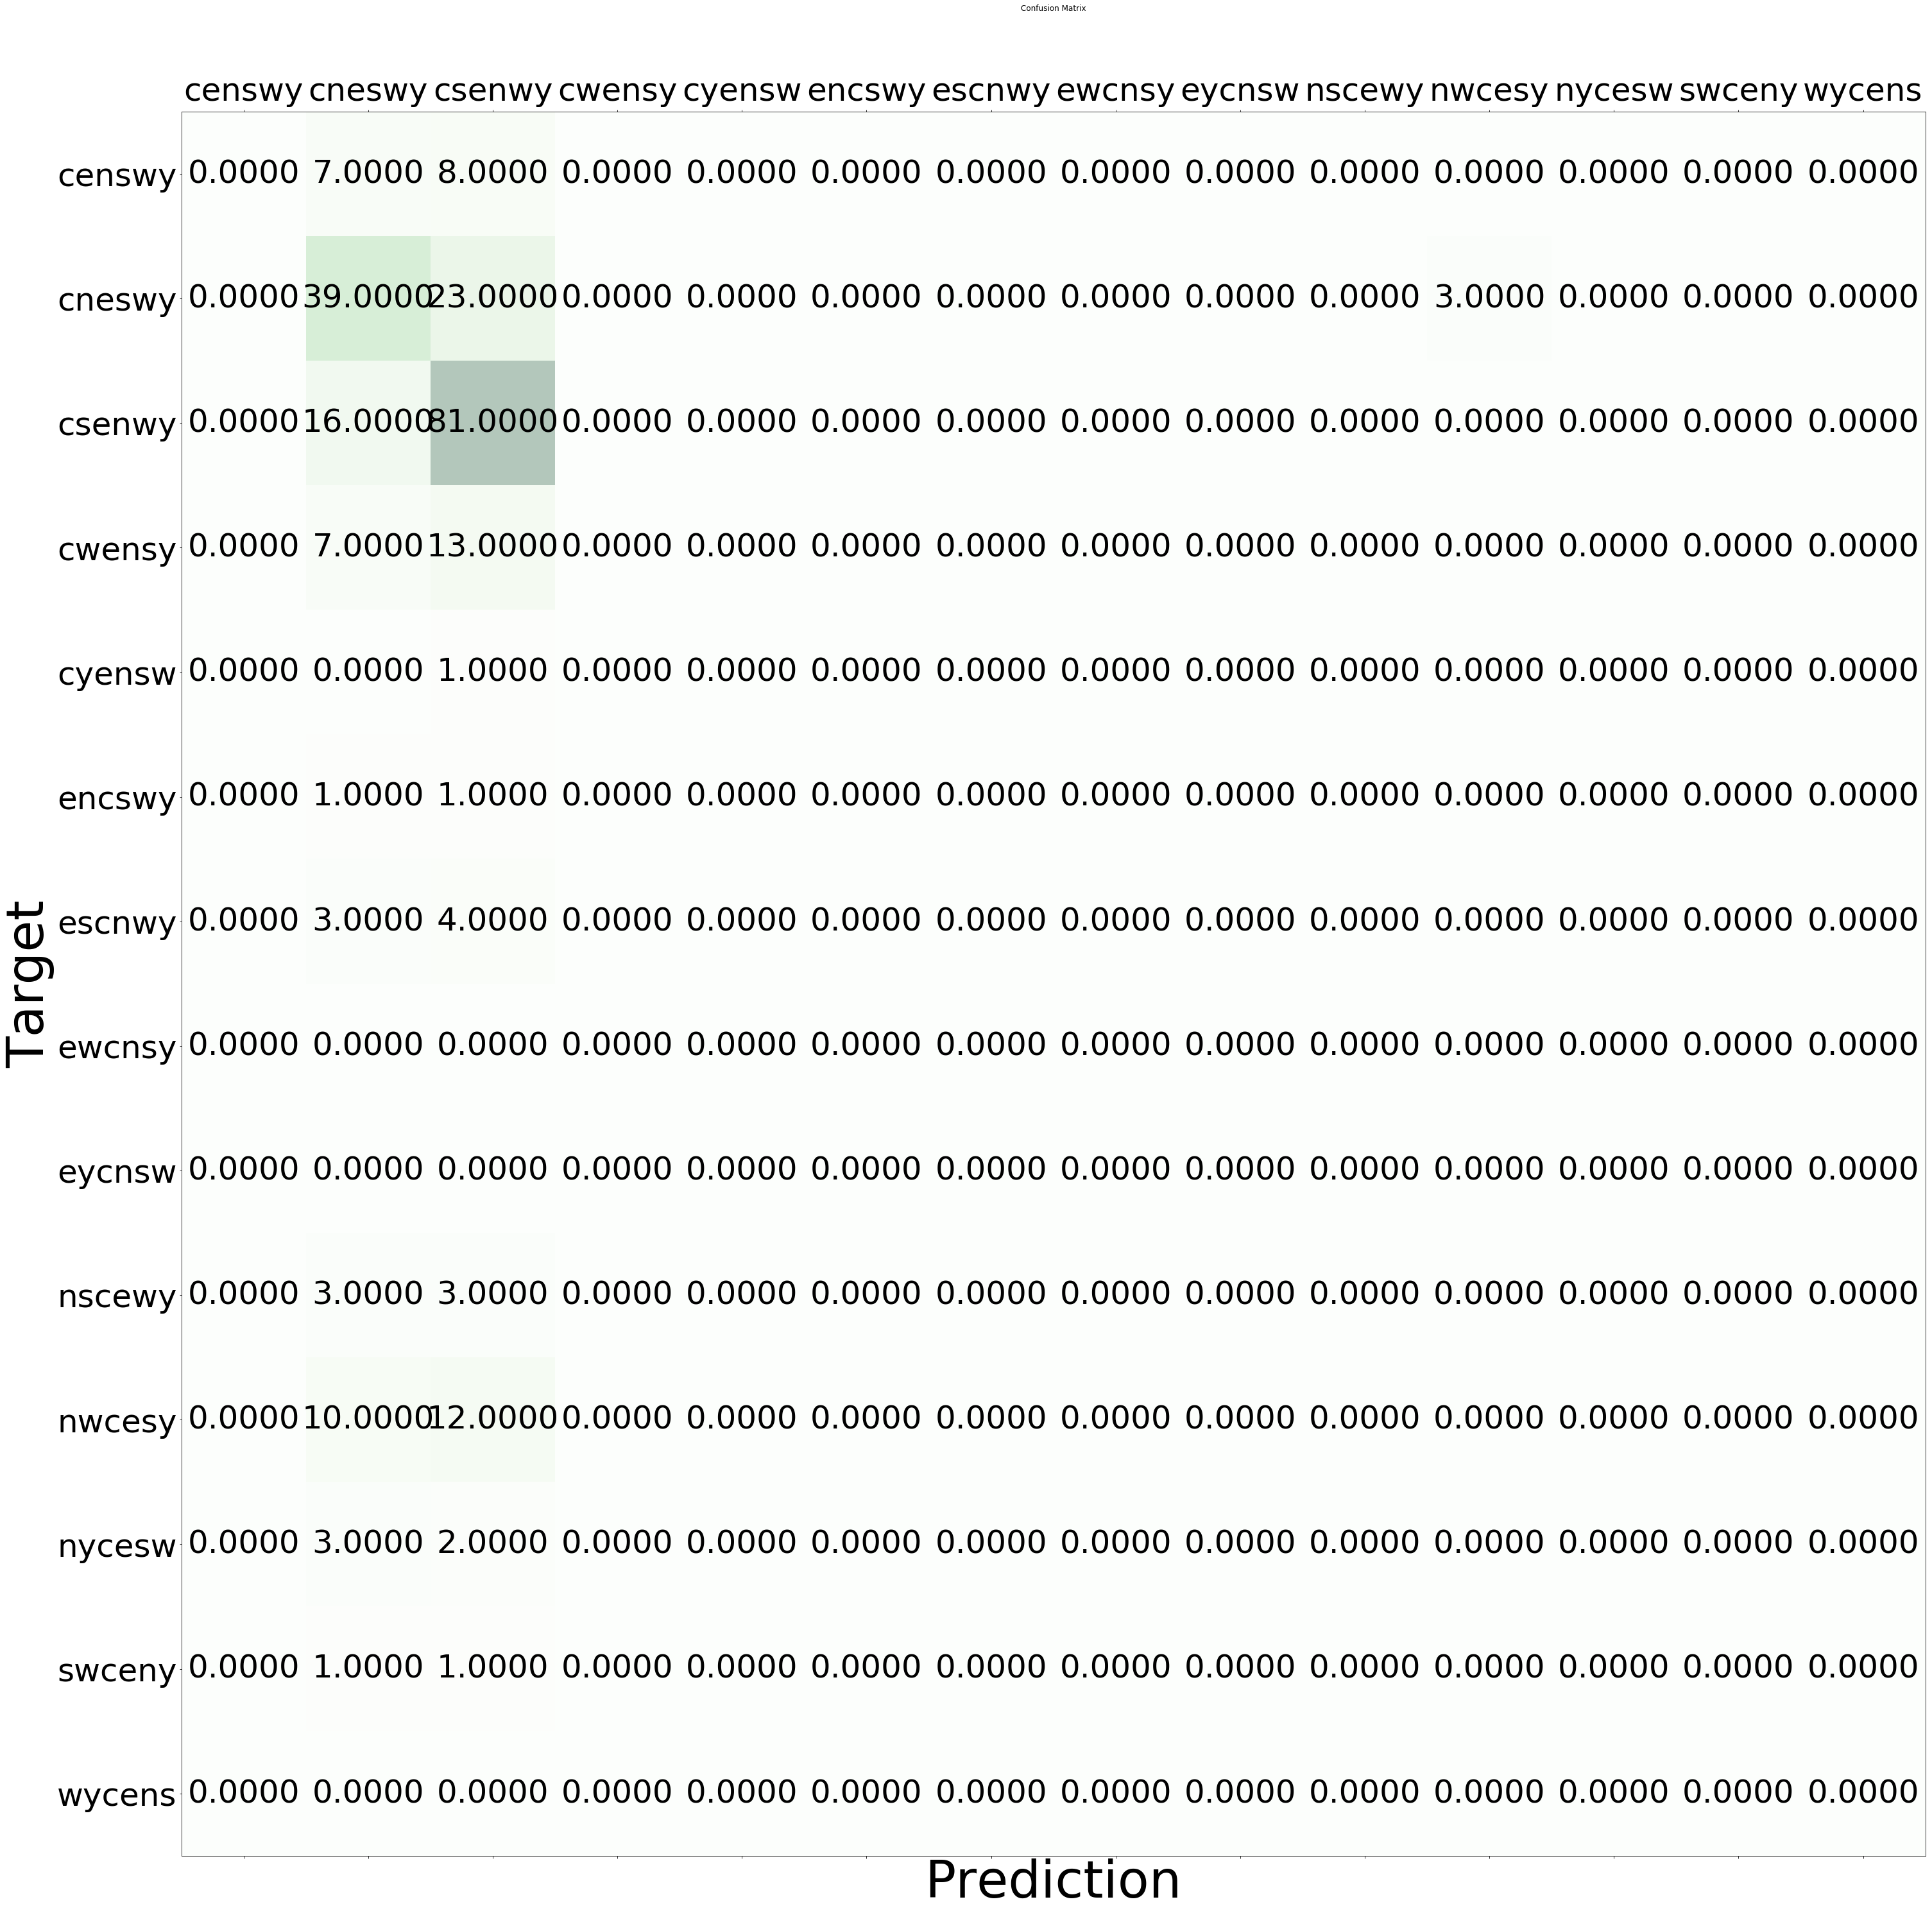

Random Forest with k = 15 :
tol_15 Classification accuracy: 0.6570247933884298
              precision    recall  f1-score   support

      censwy       0.65      0.86      0.74       120
      ecnswy       0.00      0.00      0.00        13
      nceswy       0.68      0.68      0.68        74
      scenwy       0.67      0.22      0.33        27
      wcensy       0.00      0.00      0.00         8

    accuracy                           0.66       242
   macro avg       0.40      0.35      0.35       242
weighted avg       0.60      0.66      0.61       242



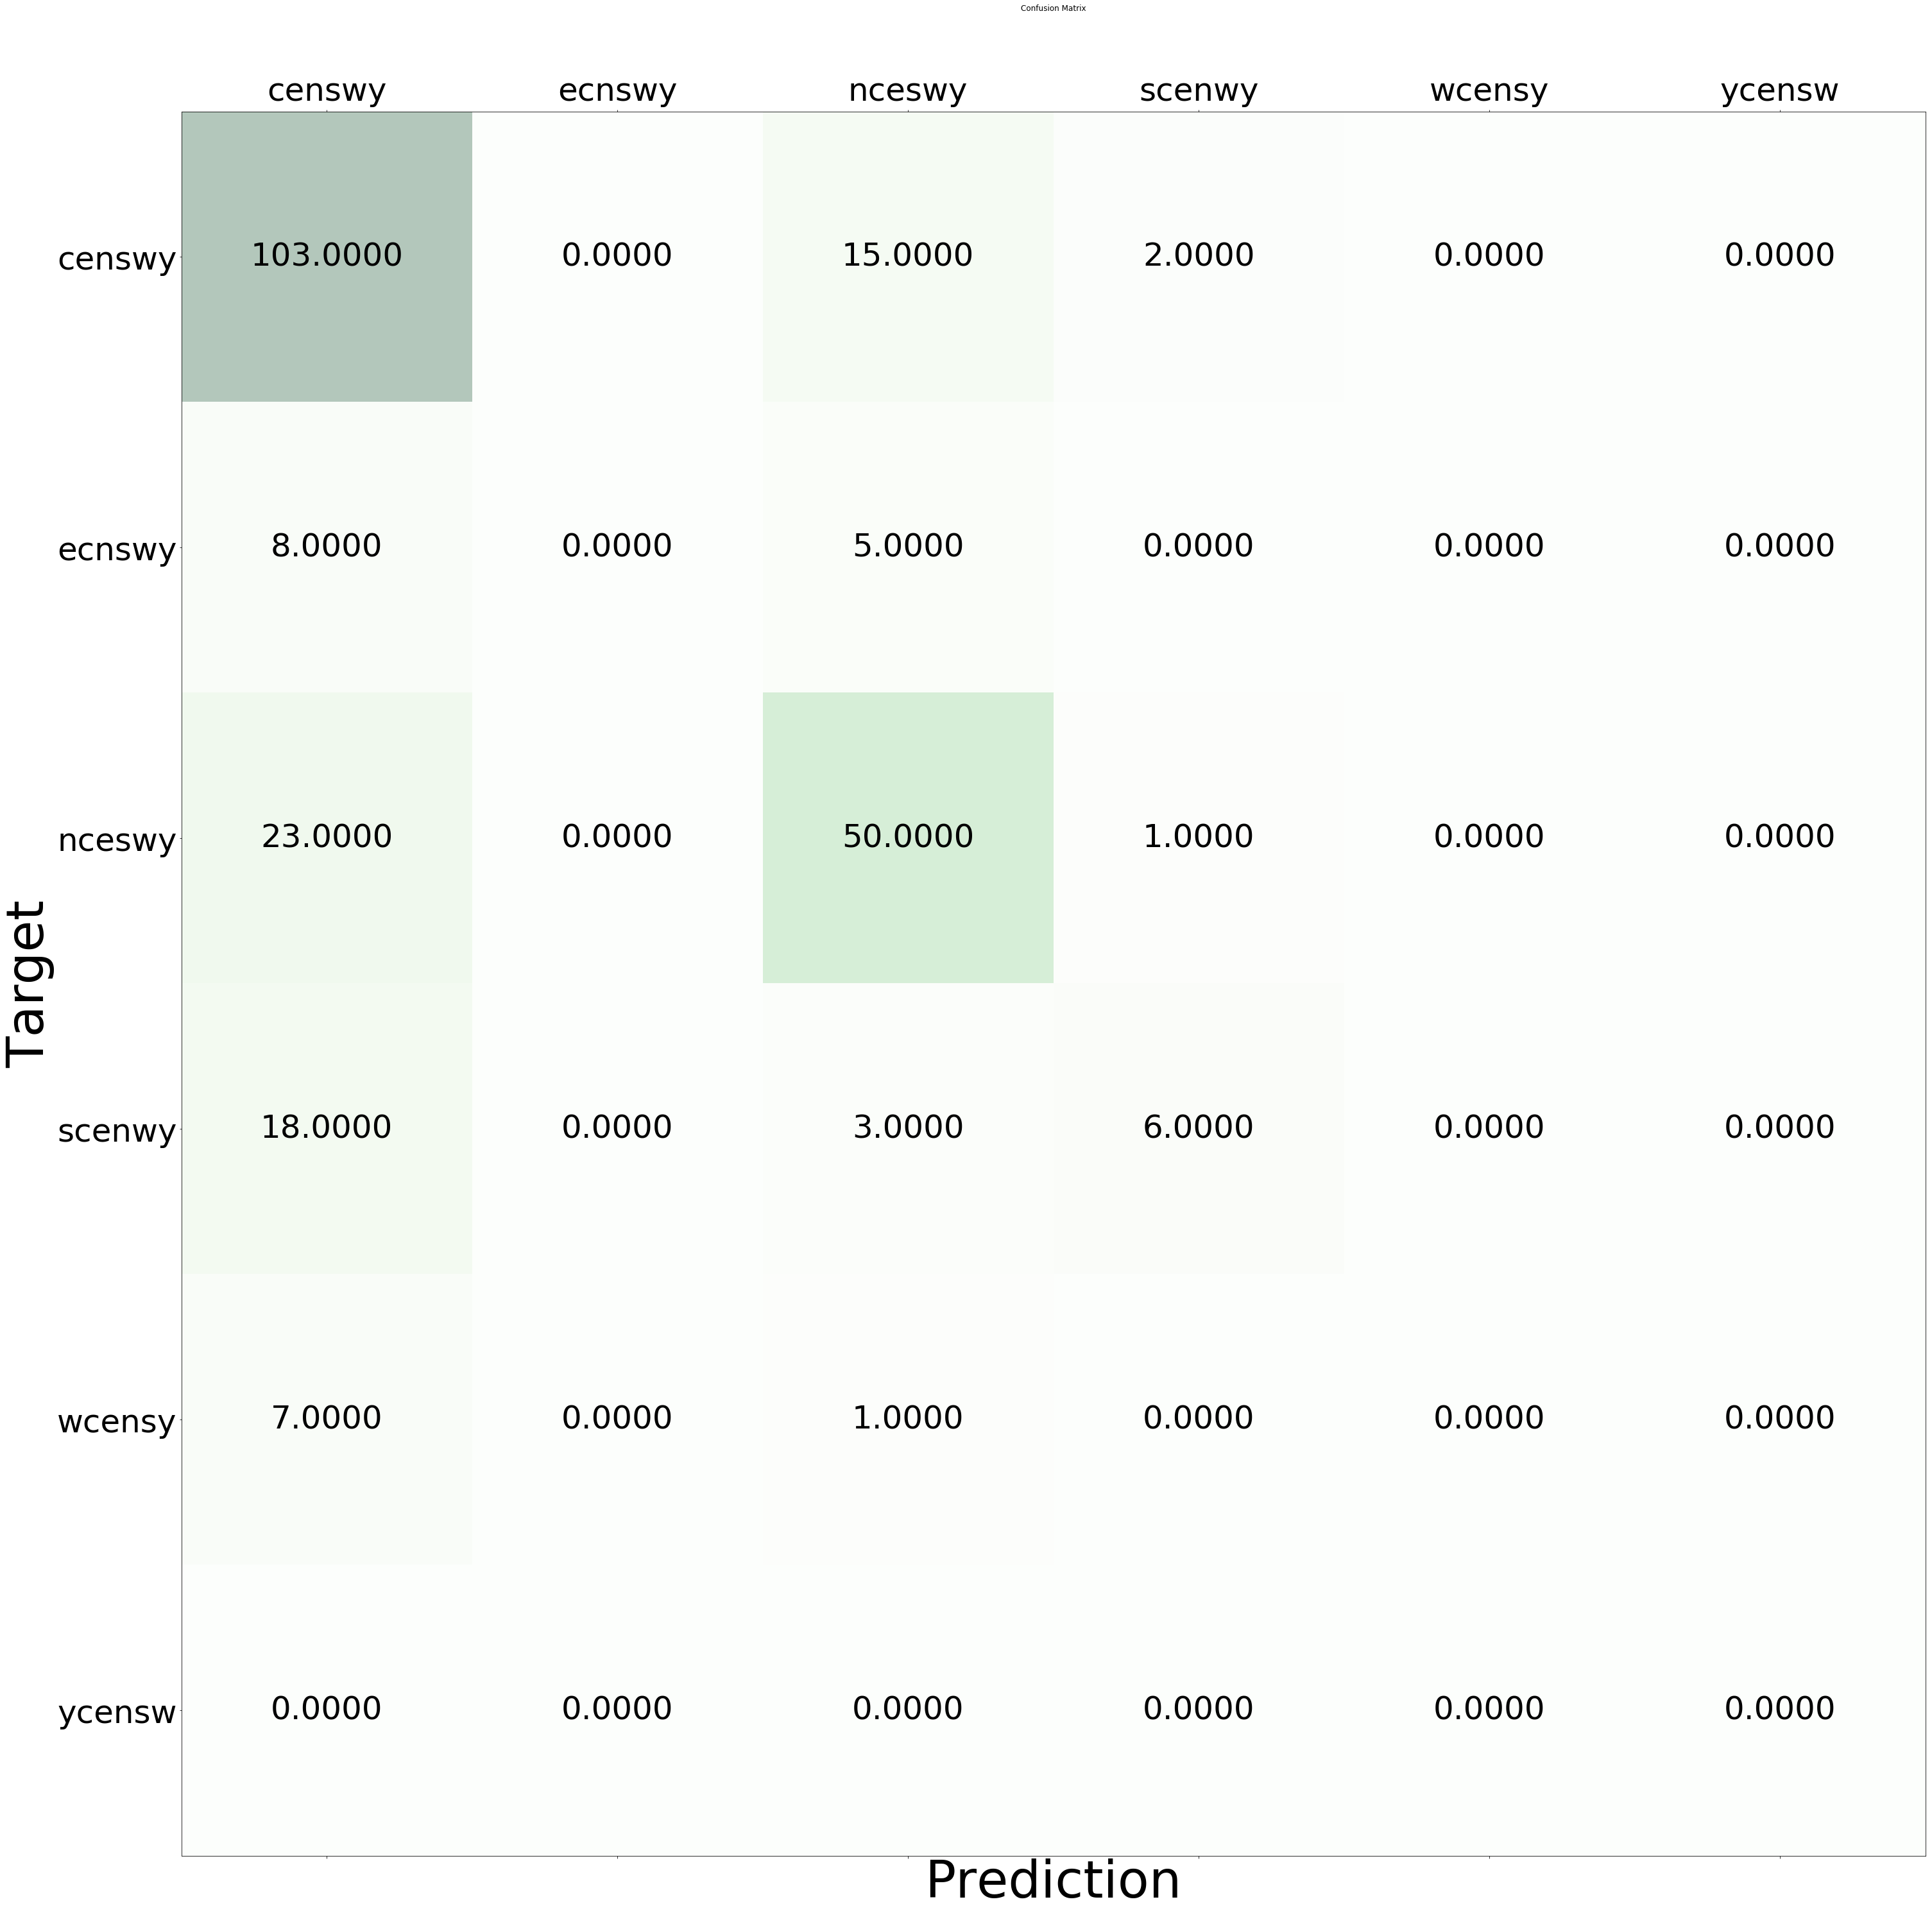

In [439]:
# random forest
from sklearn.ensemble import RandomForestClassifier

def random_forest_hold(k, i):
    print("Random Forest with k =", k, ":")
    print(y_categorical_col[i], end=' ')
    rand_forest = RandomForestClassifier(n_estimators=k, max_depth=8, min_samples_leaf=5)

    holdout_func(X, y.iloc[:, i], rand_forest, i)
    plt.show()

for i in range(6):
    class_names = list(le_name_mapping[i].keys())
    random_forest_hold(15, i)

In [440]:
"""
def random_forest_KFold(k):
    print("Random Forest by KFold with k =", k)
    rand_forest = RandomForestClassifier(n_estimators=k, max_depth=8, min_samples_leaf=5)

    KFold_func(X, y, 3, rand_forest)
    plt.show()
    
X = np.array(X)
y = np.array(y.iloc[:, 4].tolist())

random_forest_KFold(10)
"""

'\ndef random_forest_KFold(k):\n    print("Random Forest by KFold with k =", k)\n    rand_forest = RandomForestClassifier(n_estimators=k, max_depth=8, min_samples_leaf=5)\n\n    KFold_func(X, y, 3, rand_forest)\n    plt.show()\n    \nX = np.array(X)\ny = np.array(y.iloc[:, 4].tolist())\n\nrandom_forest_KFold(10)\n'